In [1]:
import os
import sys

sys.path.append(os.path.join('.', 'pytorch_yolo_v3'))

In [2]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
from darknet import Darknet
from preprocess import prep_image, inp_to_image, letterbox_image
import pandas as pd
import random 
import pickle as pkl
import argparse

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas


        
def prep_image(orig_im, inp_dim):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """

#     orig_im = cv2.imread(img)
    dim = orig_im.shape[1], orig_im.shape[0]
    img = (letterbox_image(orig_im, (inp_dim, inp_dim)))
    img_ = img[:,:,::-1].transpose((2,0,1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im, dim

def prep_image_pil(img, network_dim):
    orig_im = Image.open(img)
    img = orig_im.convert('RGB')
    dim = img.size
    img = img.resize(network_dim)
    img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes()))
    img = img.view(*network_dim, 3).transpose(0,1).transpose(0,2).contiguous()
    img = img.view(1, 3,*network_dim)
    img = img.float().div(255.0)
    return (img, orig_im, dim)

def inp_to_image(inp):
    inp = inp.cpu().squeeze()
    inp = inp*255
    try:
        inp = inp.data.numpy()
    except RuntimeError:
        inp = inp.numpy()
    inp = inp.transpose(1,2,0)

    inp = inp[:,:,::-1]
    return inp

In [4]:
colors = pkl.load(open("pytorch_yolo_v3/pallete", "rb"))

def write(x, results):
    c1 = tuple(map(lambda x: int(x.item()*1.6), tuple(x[1:3].int())))
    c2 = tuple(map(lambda x: int(x.item()*1.6), tuple(x[3:5].int())))
#     c1 = tuple(x[1:3].int())
#     c2 = tuple(x[3:5].int())
    img = results
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = random.choice(colors)
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2, color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
    return img

In [5]:
model = Darknet("pytorch_yolo_v3/cfg/yolov3.cfg")
model.load_weights("pytorch_yolo_v3/yolov3.weights")

In [6]:
num_classes = 80
classes = load_classes('pytorch_yolo_v3/data/coco.names') 

In [7]:
_ = model.cuda()

In [8]:
CUDA = torch.cuda.is_available()

In [9]:
videofile = './Novgorod_2019-04-05-15_15_00.mp4'
cap = cv2.VideoCapture(videofile)

C:\Users\Alexey\Miniconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


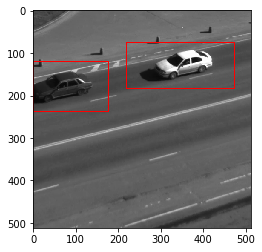

In [14]:
videofile = './Novgorod_2019-04-05-15_15_00.mp4'
cap = cv2.VideoCapture(videofile)

ret, frame = cap.read()
frame = frame[1500:2500,1500:2500]
frame = cv2.resize(frame, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
img = (torch.FloatTensor(frame).permute(2,0,1).unsqueeze(0)/255).cuda()

with torch.no_grad():
    prediction = model(img, CUDA)
prediction = write_results(prediction.cuda(), confidence, num_classes, nms = True, nms_conf = nms_thesh)

trackers = []
bboxes = []
for pred in prediction:
    tracker = cv2.TrackerKCF_create()
    trackers.append(tracker)

    c1 = tuple(map(lambda x: int(x.item()*1.6), tuple(pred[1:3].int())))
    c2 = tuple(map(lambda x: int(x.item()*1.6), tuple(pred[3:5].int())))
    bbox = c1+c2
    bbox = [x if x>0 else 0 for x in bbox]
    bbox = [x if x<511 else 511 for x in bbox]
    bboxes.append(bbox)
    tracker.init(frame, (bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1]))
    frame = cv2.rectangle(frame, tuple(bbox[0:2]), tuple(bbox[2:4]), (255,0,0), 2, 1)
plt.imshow(frame)

In [74]:
[classes[int(x[-1])] for x in prediction if int(x[0]) == 0]

['car', 'car']

In [13]:
while cap.isOpened():
    try:
        ret, frame = cap.read()
        frame = frame[1500:2500,1500:2500]
        frame = cv2.resize(frame, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        ok, bbox = tracker.update(frame)
        img = (torch.FloatTensor(frame).permute(2,0,1).unsqueeze(0)/255).cuda()
        

        with torch.no_grad():
            prediction = model(img, CUDA)
        prediction = write_results(prediction.cuda(), confidence, num_classes, nms = True, nms_conf = nms_thesh)    
        a = list(map(lambda x: write(x, frame), prediction))
        if ok:
            # Tracking success
            p1 = (int(bbox[0]), int(bbox[1]))
            p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            cv2.rectangle(a[0], p1, p2, (255,0,0), 2, 1)
        else :
            # Tracking failure
            cv2.putText(a[0], "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)

        cv2.imshow('video', a[0])
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
    except Exception(e):
        print(e)
        cv2.destroyAllWindows()
        break

C:\Users\Alexey\Miniconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [209]:
while cap.isOpened():
#     for i in range(pass_step):
#         cap.read()
    try:
        ret, frame = cap.read()
        frame = frame[1500:2500,1500:2500]
        frame = cv2.resize(frame, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        img = (torch.FloatTensor(frame).permute(2,0,1).unsqueeze(0)/255).cuda()

        with torch.no_grad():
            prediction = model(img, CUDA)
        prediction = write_results(prediction.cuda(), confidence, num_classes, nms = True, nms_conf = nms_thesh)
        a = list(map(lambda x: write(x, frame), prediction))

        cv2.imshow('video', a[0])
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
    except Exception(e):
        print(e)
        cv2.destroyAllWindows()
        break

C:\Users\Alexey\Miniconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
